In [30]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency

# ML metrics (for model evaluation)
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss



# 1. EDA

In [31]:
# Load Dataset
pricing_data = pd.read_csv("PA Assessment Task 2024v1 - Dataset.csv")
# pricing_data.head()

In [32]:
# Dimensions of the dataset (rows, columns) - before data cleaning
pricing_data.shape

(8867, 21)

In [33]:
# Returns True if there are any duplicate rows
pricing_data.duplicated().any()

# Counts how many duplicate rows exist (excluding the first occurrence)
num_duplicates = pricing_data.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Show all duplicate rows including their values
duplicates = pricing_data[pricing_data.duplicated()]
print(duplicates)


Number of duplicate rows: 2
       offerdate  sold_premium  offered_premium  purchase_price purchase_date  \
3829  03-04-2023           NaN            26.52           300.0    31-03-2023   
4739  13-04-2023           NaN            64.68           600.0    06-03-2022   

     item age pricing_point  predictedconversionrate  plan_flag  plan_count  \
3829        3      ASIS FEE                      1.0          0         0.0   
4739      403      ASIS FEE                      1.0          0         0.0   

      ...  planscancelled_lastyear_count  claims_count  claim_amount  \
3829  ...                            0.0           0.0           0.0   
4739  ...                            0.0           0.0           0.0   

      price_diff  IsModel sale_flag  base_rate  manufacturerbrandname_enc  \
3829         0.0       No         0      26.52                        129   
4739         0.0       No         0      64.68                          7   

      itemcategoryname_enc  itemsupercate

In [34]:
# Keep only the first occurrence of each duplicate row
pricing_data = pricing_data.drop_duplicates()


In [35]:
# # Missing values in each column
# pricing_data.isna().sum()

# Show only columns with missing values and their counts
missing_summary = pricing_data.isna().sum()
missing_summary = missing_summary[missing_summary > 0]
print(missing_summary)


sold_premium                     6874
purchase_price                      1
plan_count                         41
plansactive_lastyear_count         41
planscancelled_lastyear_count      41
claims_count                     1149
claim_amount                     1149
dtype: int64


### Handling missing values.

**a. sold_premium**

We will leave missing values as they are, because imputing does not make sense.

Dropping them would remove all rows where sale_flag = 0.

Imputing with zero would imply the policy was sold for free.

Using median/mode is invalid since these customers never accepted the offer, so no premium was paid. 




**b. purchase_price**

Checked for other records with the same Manufacturer Brand + Item Category + Item Super Category to impute purchase_price, but none were available.

Imputing mean/median could distort pricing, and setting it to 0 would incorrectly suggest the item was free.

Therefore, the row was omitted for now

In [36]:
# dropping the missing purchase_price row.
pricing_data = pricing_data.dropna(subset=['purchase_price'])

In [37]:
# Check dataset dimensions again to confirm that missing values were handled successfully
pricing_data.shape

(8864, 21)

**c. plan_count**

- All missing values in `plan_count` occur when `plan_flag = 0`, meaning the customer has no active plans.  
- Therefore, it is consistent to impute all missing `plan_count` values as **0**.


In [38]:
# Count missing values in plan_count grouped by plan_flag (0 vs 1)
check_missing = pricing_data.groupby("plan_flag")[["plan_count"]].apply(lambda x: x.isna().sum())
print(check_missing)


           plan_count
plan_flag            
0                  41
1                   0


In [39]:
# Impute missing plan_count as 0 when plan_flag = 0 (no active plans)
pricing_data.loc[(pricing_data['plan_flag'] == 0) & (pricing_data['plan_count'].isna()), 'plan_count'] = 0



**d. plansactive_lastyear_count & planscancelled_lastyear_count**

Case 1: plan_flag = 0 and sold_premium is not null

The customer currently has no active plan (plan_flag = 0), but a premium was sold in the past (sold_premium not null).

This indicates the customer had an active plan last year and cancelled it. Hence,

plansactive_lastyear_count = 1

planscancelled_lastyear_count = 1

**Assumption** = It is assumed that the customer had atleast one active plan last year which was subsequently cancelled, there may have be more plans active.

Case 2: All other cases

Interpretation: No evidence of active or cancelled plans last year. Hence,

plansactive_lastyear_count = 0

planscancelled_lastyear_count = 0

In [40]:
# Identify records with missing values in plansactive_lastyear_count & planscancelled_lastyear_count
missing_mask = pricing_data['plansactive_lastyear_count'].isna() | pricing_data['planscancelled_lastyear_count'].isna()

# Focus only on missing records
subset = pricing_data[missing_mask]

# Check plan_flag = 0 (means no active plan now)
# If sold_premium not null → indicates they had a plan last year and cancelled it
condition = (subset['plan_flag'] == 0) & (subset['sold_premium'].notna())

# Count how many such cases
count_cases = condition.sum()
print(f"Number of missing cases with plan_flag=0 and sold_premium not null: {count_cases}")

Number of missing cases with plan_flag=0 and sold_premium not null: 4


In [41]:
# Impute values
# If sold_premium not null → set both to 1
# Else → set both to 0

# Loop through missing rows and impute with if-else
for idx, row in pricing_data[missing_mask].iterrows():
    if (row['plan_flag'] == 0) and pd.notna(row['sold_premium']):
        # If no active plan now, but sold_premium exists → means had a plan last year & cancelled
        pricing_data.at[idx, 'plansactive_lastyear_count'] = 1
        pricing_data.at[idx, 'planscancelled_lastyear_count'] = 1
    else:
        # Otherwise → no active or cancelled plans last year
        pricing_data.at[idx, 'plansactive_lastyear_count'] = 0
        pricing_data.at[idx, 'planscancelled_lastyear_count'] = 0


**e. claims_count, claim_amount**  
**Assumption:** For all missing values are imputed as 0.

**Rationale:** There is no supporting information such as claim history, external claims databases, policyholder statements, or insurer-provided records to confirm whether a missing entry corresponds to no claims or simply incomplete data entry.

In the absence of this necessary context, the safest assumption is that missing values represent no claims reported.

**Impact:** This approach ensures consistency in downstream analysis and prevents inflation of claim-related features due to null handling methods (e.g., mean or median imputation).

However, if the missingness is due to data entry issues rather than genuine absence of claims, this assumption may understate actual claims experience.

In [42]:
# Impute missing values
pricing_data[["claims_count", "claim_amount"]] = (
    pricing_data[["claims_count", "claim_amount"]].fillna(0)
)


**Caveat:** If additional information (e.g., claim submission dates, adjuster notes, insurer back-office feeds, or external claims bureau data) becomes available, a more accurate imputation strategy will be adopted — such as distinguishing between truly zero claims and missing but non-zero claims.

In [43]:
# # Show only columns with missing values and their counts
# missing_summary = pricing_data.isna().sum()
# missing_summary = missing_summary[missing_summary > 0]
# print(missing_summary)


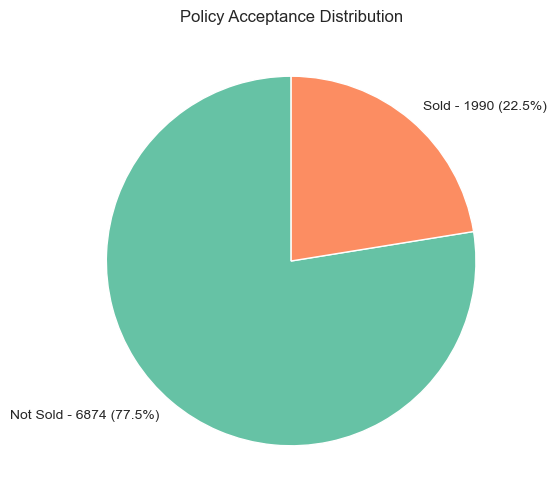

In [45]:
# Distribution of Sale Flag 
 
# Value counts of sale_flag
sale_counts = pricing_data['sale_flag'].value_counts()

# Custom labels with counts + percentage
labels = [f"{'Sold' if i==1 else 'Not Sold'} - {count} ({count/sale_counts.sum():.1%})"
          for i, count in sale_counts.items()]

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(
    sale_counts,
    labels=labels, 
    startangle=90,
    colors=sns.color_palette("Set2")
)

plt.title("Policy Acceptance Distribution")
plt.savefig("Charts/Policy_Acceptance_Distribution_Pie_chart.png", dpi=300, bbox_inches='tight')  
plt.show()

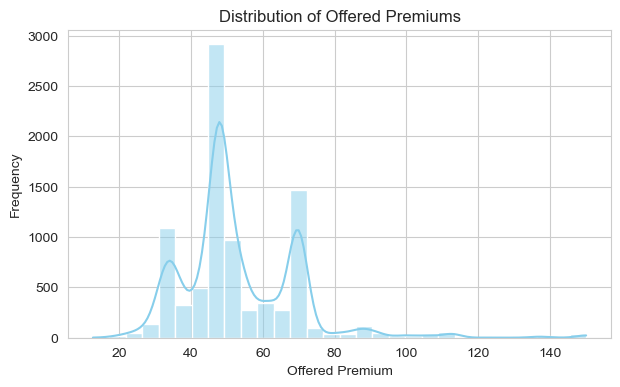

In [46]:
# Offered Premium Distribution

plt.figure(figsize=(7,4))
sns.histplot(pricing_data["offered_premium"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Offered Premiums")
plt.xlabel("Offered Premium")
plt.ylabel("Frequency")

plt.savefig("Charts/Distribution of Offered Premiums_Histogram_chart.png", dpi=300, bbox_inches='tight')  
plt.show()


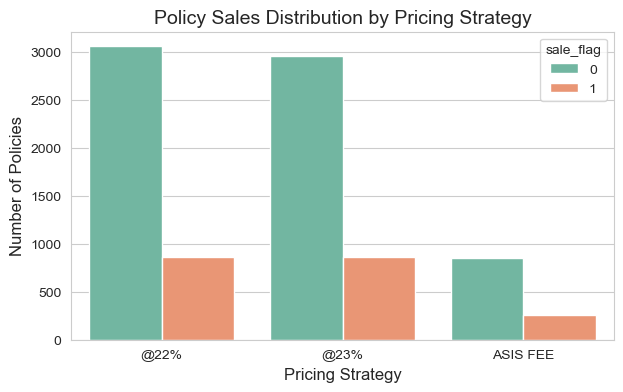

In [47]:
# Set figure size
plt.figure(figsize=(7,4))

# Countplot: number of policies sold vs not sold for each pricing strategy
sns.countplot(
    x="pricing_point",  # x-axis: pricing strategies
    hue="sale_flag",    # hue: whether policy was sold (1) or not sold (0)
    data=pricing_data,  # data source
    palette="Set2"      # optional: color palette
)

# Add title and axis labels
plt.title("Policy Sales Distribution by Pricing Strategy", fontsize=14)
plt.xlabel("Pricing Strategy", fontsize=12)
plt.ylabel("Number of Policies", fontsize=12)


plt.savefig("Charts/Policy Sales Distribution by Pricing Strategy_GroupBar_chart.png", dpi=300, bbox_inches='tight')  
plt.show()


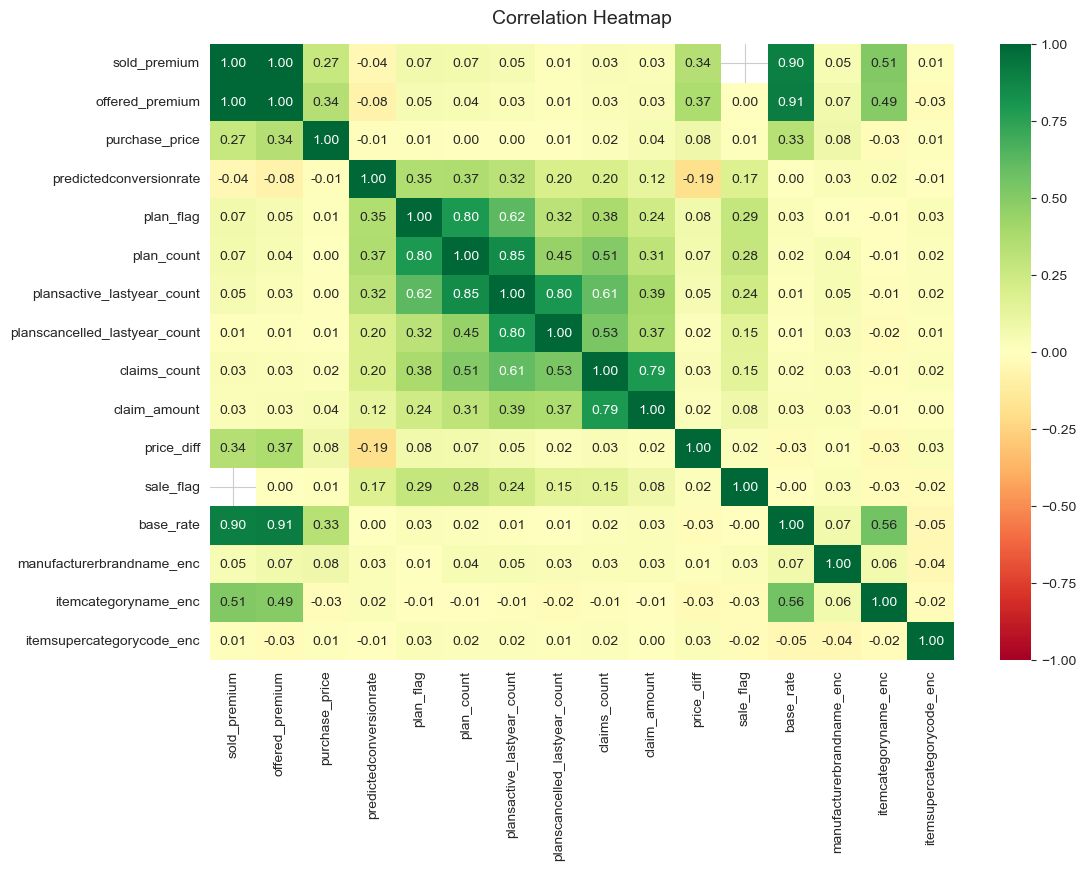

In [48]:
# Plot a correlation heatmap for all numeric columns in pricing_data
plt.figure(figsize=(12,8))   # Set figure size (width x height)

sns.heatmap(
    pricing_data.corr(numeric_only=True),  # Compute correlation matrix
    annot=True,                            # Show correlation values on the heatmap
    cmap="RdYlGn",                         # Color map: Red (-1) → Yellow (0) → Green (+1)
    fmt=".2f",                             # Format numbers to 2 decimal places
    annot_kws={"size":10},                 # Set font size of annotations
    vmin=-1, vmax=1,                       # Fix color scale from -1 to +1
    center=0                               # Make 0 the midpoint (neutral color)
)

plt.title("Correlation Heatmap", fontsize=14, pad=15)  # Add title with font size and padding

# Save the figure to the current working directory as a high-resolution PNG
plt.savefig("Charts/correlation_heatmap.png", dpi=300, bbox_inches='tight')  

plt.show()  # Display the heatmap

In [49]:
# Descriptive stats of the cleaned dataset
pricing_data.describe()

,sold_premium,offered_premium,purchase_price,predictedconversionrate,plan_flag,plan_count,plansactive_lastyear_count,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,sale_flag,base_rate,manufacturerbrandname_enc,itemcategoryname_enc,itemsupercategorycode_enc
count,1990.000000,8864.000000,8864.000000,8864.000000,8864.000000,8864.000000,8864.000000,8864.000000,8864.000000,8864.000000,8864.000000,8864.000000,8864.000000,8864.000000,8864.000000,8864.000000
mean,53.091920,53.032392,406.704533,0.315809,0.197089,0.407040,0.680957,0.232401,0.183439,25.364560,0.080783,0.224504,49.093078,53.753723,22.599842,4.677798
std,15.116414,16.273163,214.183314,0.298110,0.397823,1.031239,1.962176,0.980186,0.839059,174.987511,0.129814,0.417279,13.564443,38.925123,10.903574,3.894812
min,18.600000,12.720000,19.990000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.298643,0.000000,18.000000,-1.000000,0.000000,0.000000
25%,45.120000,45.000000,295.000000,0.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.480000,16.000000,12.000000,2.000000
50%,48.240000,48.120000,330.000000,0.190000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069149,0.000000,45.960000,57.000000,19.000000,4.000000
75%,63.420000,63.600000,471.615000,0.370000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.169096,0.000000,59.640000,74.000000,36.000000,4.000000
max,150.000000,150.000000,1200.000000,1.000000,1.000000,5.000000,32.000000,25.000000,30.000000,10523.030000,0.299886,1.000000,150.000000,130.000000,37.000000,16.000000


# 2. Compare the pricing performance of all strategies 



**Summary table grouped by pricing_point to understand how offers perform at different price levels.**

offers: total number of offers made at this pricing point

avg_base: average base rate for the pricing point

avg_offered_premium: average premium offered to customers

avg_sold_premium: average premium actually sold

avg_price_increase: average difference between offered price and base rate

conversion: proportion of offers that were accepted (sale_flag mean)

This table helps identify trends in pricing, customer acceptance, and profitability across different pricing points.

In [50]:
# Summary table grouped by 'pricing_point' to understand offer performance
summary = pricing_data.groupby("pricing_point").agg(
    offers = ('sale_flag', 'count'),
    avg_base = ('base_rate', 'mean'),
    avg_offered_premium = ('offered_premium', 'mean'),
    avg_sold_premium = ('sold_premium', 'mean'),
    avg_price_increase = ('price_diff', 'mean'),
    conversion = ('sale_flag', 'mean')
).reset_index()

print(summary)

  pricing_point  offers   avg_base  avg_offered_premium  avg_sold_premium  \
0          @22%    3922  49.203957            55.216430         55.768714   
1          @23%    3827  49.014236            51.976650         51.482768   
2      ASIS FEE    1115  48.973668            48.973668         49.572923   

   avg_price_increase  conversion  
0            0.124335    0.220041  
1            0.059686    0.226548  
2            0.000000    0.233184  


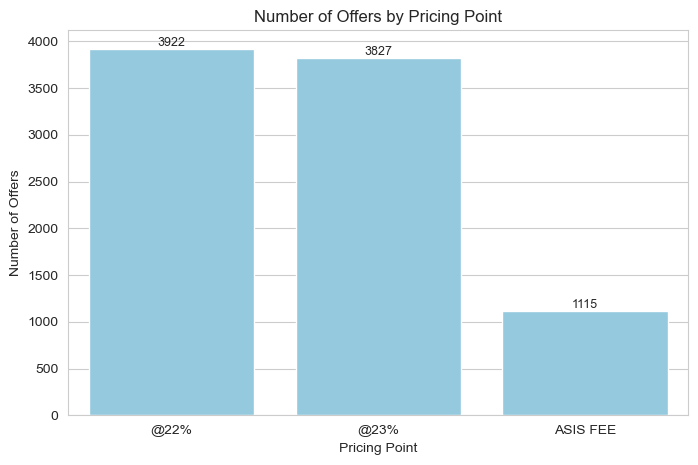

In [51]:
# ================================
# 1. Number of Offers per Pricing Point
# ================================

# Compute the number of offers for each pricing point.
# We use 'sale_flag' as a proxy for counting offers since each row represents an offer.
# 'groupby' aggregates the data by pricing_point, and 'count' gives the total offers per group.
offers_count = pricing_data.groupby("pricing_point")["sale_flag"].count().reset_index(name="offers")

# Plot a bar chart to visualize the number of offers per pricing point.
# This helps us understand which pricing points are most frequently offered.
plt.figure(figsize=(8,5))
bars = sns.barplot(
    x="pricing_point",  # X-axis: different pricing points
    y="offers",         # Y-axis: count of offers
    data=offers_count,  # Data source
    color="skyblue"     # Bar color for aesthetics
)

# Add labels on top of each bar to clearly show the exact number of offers.
# This improves readability and makes the chart more informative for stakeholders.
for bar in bars.patches:
    height = bar.get_height()
    bars.text(
        bar.get_x() + bar.get_width()/2,  # X position = center of bar
        height,                            # Y position = top of bar
        f"{int(height)}",                  # Label text as integer
        ha="center", va="bottom", fontsize=9
    )

# Add chart title and axis labels for clarity.
plt.title("Number of Offers by Pricing Point")
plt.xlabel("Pricing Point")
plt.ylabel("Number of Offers")

# Save the figure as a high-resolution PNG file for reporting purposes.
plt.savefig("Charts/Number of offers by pp_Bar_Charts.png", dpi=300, bbox_inches='tight')

# Display the chart
plt.show()


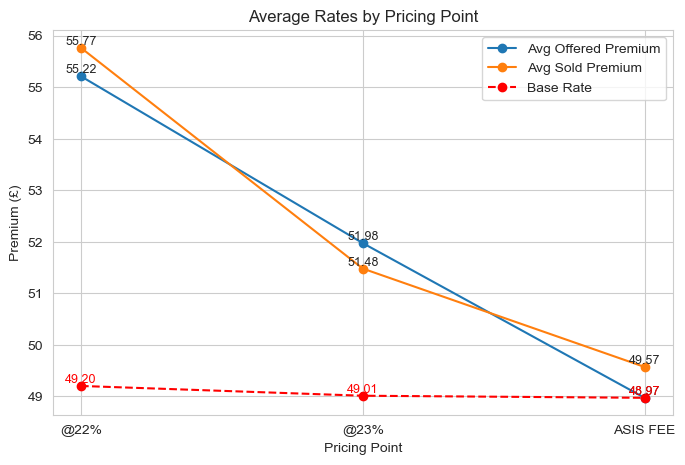

In [52]:
# ================================
# 2. Average base_rate vs offered Premiums vs sold Premium (Line Chart)
# ================================

# Set figure size for the line chart
plt.figure(figsize=(8,5))

# Plot the Average Offered Premium line
# This shows the average price offered to customers at each pricing point.
plt.plot(
    summary["pricing_point"], 
    summary["avg_offered_premium"], 
    marker='o', 
    label="Avg Offered Premium"
)

# Plot the Average Sold Premium line
# This shows the average price at which policies were actually sold.
# Comparing this to offered premium helps understand discounts or deviations.
plt.plot(
    summary["pricing_point"], 
    summary["avg_sold_premium"], 
    marker='o', 
    label="Avg Sold Premium"
)

# Plot the Base Rate line
# Base Rate represents the standard pricing point without adjustments.
# Using a dashed red line differentiates it from premiums to highlight deviations.
plt.plot(
    summary["pricing_point"], 
    summary["avg_base"], 
    marker='o', 
    label="Base Rate", 
    linestyle='--', 
    color='red'
)

# Add numeric labels on top of Avg Offered Premium points
# This helps in quickly reading the exact values for reporting/analysis.
for x, y in zip(summary["pricing_point"], summary["avg_offered_premium"]):
    plt.text(x, y, f"{y:.2f}", ha="center", va="bottom", fontsize=9)

# Add numeric labels on top of Avg Sold Premium points
for x, y in zip(summary["pricing_point"], summary["avg_sold_premium"]):
    plt.text(x, y, f"{y:.2f}", ha="center", va="bottom", fontsize=9)

# Add numeric labels on top of Base Rate points
# Colored red to match the line for clarity.
for x, y in zip(summary["pricing_point"], summary["avg_base"]):
    plt.text(x, y, f"{y:.2f}", ha="center", va="bottom", fontsize=9, color='red')

# Set chart title and axis labels
plt.title("Average Rates by Pricing Point")  # Describes what the chart shows
plt.xlabel("Pricing Point")                  # X-axis: pricing categories
plt.ylabel("Premium (£)")                    # Y-axis: monetary

# Display legend to distinguish lines
plt.legend()

# Save the chart as a high-resolution PNG for reporting or presentations
plt.savefig("Charts/Average rates_Charts.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

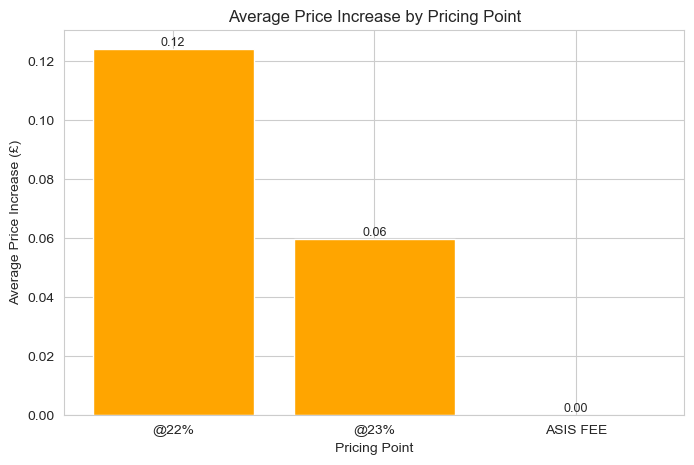

In [53]:
# ================================
# 3. Average Price Increase (Bar Chart with Labels)
# ================================

# Create a figure with specified size
# Why: A larger figure ensures readability of bars and labels
plt.figure(figsize=(8,5))

# Plot a bar chart of average price increase by pricing point
# Why: Visualizing average price increase helps us understand pricing trends across different pricing points
bars = plt.bar(summary["pricing_point"], summary["avg_price_increase"], color="orange")

# Set the title and axis labels
# Why: Titles and labels make the chart self-explanatory for reporting or presentations
plt.title("Average Price Increase by Pricing Point")
plt.xlabel("Pricing Point")
plt.ylabel("Average Price Increase (£)")

# Add value labels on top of each bar
# Why: Showing the exact values on the chart makes it easier to interpret without having to hover or refer to the table
for bar in bars:
    height = bar.get_height()  # Get the height of each bar (the value being plotted)
    plt.text(
        bar.get_x() + bar.get_width()/2,  # X position = center of the bar
        height,                           # Y position = top of the bar
        f"{height:.2f}",                  # Format the value to 2 decimal places
        ha="center", va="bottom", fontsize=9
    )

# Save the chart as a high-resolution PNG file
# Why: Saving the chart allows us to use it in reports, presentations, or dashboards
plt.savefig("Charts/Avg price Increase_Bar_Charts.png", dpi=300, bbox_inches='tight')

# Display the chart
plt.show()


In [56]:
print(summary)

  pricing_point  offers   avg_base  avg_offered_premium  avg_sold_premium  \
0          @22%    3922  49.203957            55.216430         55.768714   
1          @23%    3827  49.014236            51.976650         51.482768   
2      ASIS FEE    1115  48.973668            48.973668         49.572923   

   avg_price_increase  conversion  
0            0.124335    0.220041  
1            0.059686    0.226548  
2            0.000000    0.233184  


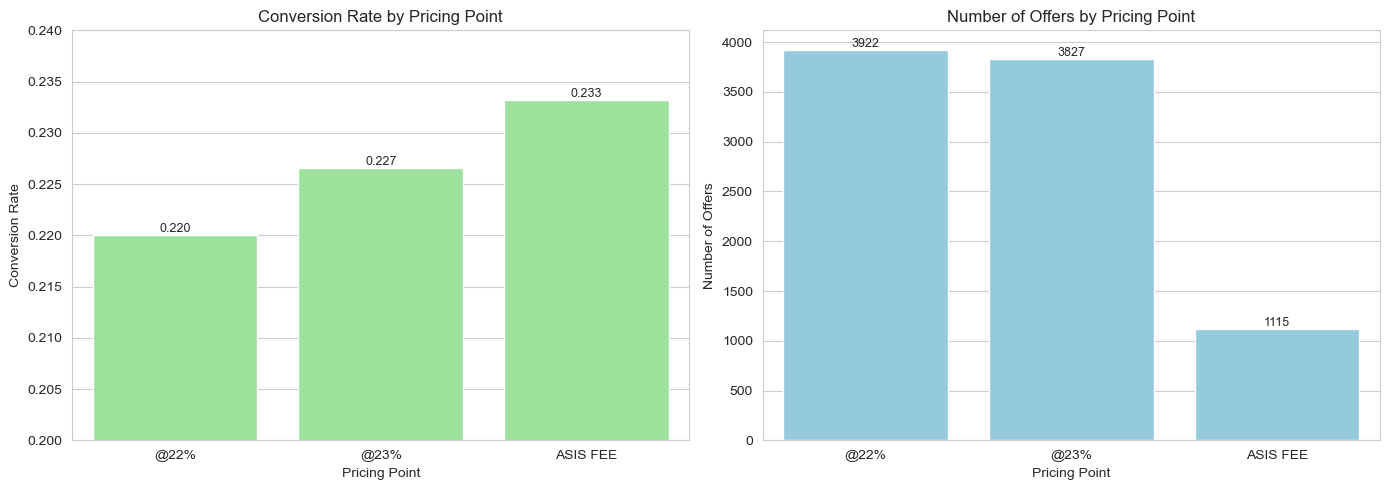

In [60]:
# Set the visual style for the plots using Seaborn
# 'whitegrid' provides a clean background with gridlines, which makes it easier to compare bar heights
sns.set_style("whitegrid")

# Create a figure with 2 subplots arranged in 1 row and 2 columns
# figsize=(14,5) sets the width and height of the overall figure
# axes will store the two subplots for individual plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# -----------------------------
# Plot 1: Conversion Rate by Pricing Point
# -----------------------------
# Plot a bar chart for conversion rates using Seaborn
# x-axis: pricing_point, y-axis: conversion_rate
# color: light green for better visual appeal
# ax=axes[0] tells matplotlib to draw this plot in the first subplot


sns.barplot(
    x="pricing_point",
    y="conversion",
    data=summary,
    color="lightgreen",
    ax=axes[0]
)

# Add labels on top of each bar to show the exact conversion rate
# This makes the chart more informative and easier to interpret
for bar in axes[0].patches:
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width()/2,  # Center the label horizontally
        height,                           # Place the label at the top of the bar
        f"{height:.3f}",                  # Format the label to 3 decimal places
        ha="center", va="bottom", fontsize=9
    )

# Set title and axis labels for the first subplot
axes[0].set_title("Conversion Rate by Pricing Point")
axes[0].set_xlabel("Pricing Point")
axes[0].set_ylabel("Conversion Rate")
axes[0].set_ylim(0.20, 0.24)  # Set y-axis limits for better visual comparison

# -----------------------------
# Plot 2: Number of Offers by Pricing Point
# -----------------------------
# Plot a bar chart for the number of offers per pricing point
# color: skyblue for differentiation from the first plot
# ax=axes[1] tells matplotlib to draw this plot in the second subplot
sns.barplot(
    x="pricing_point",
    y="offers",
    data=summary,
    color="skyblue",
    ax=axes[1]
)

# Add labels on top of each bar to show the exact number of offers
for bar in axes[1].patches:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{int(height)}",  # Show labels as integers
        ha="center", va="bottom", fontsize=9
    )

# Set title and axis labels for the second subplot
axes[1].set_title("Number of Offers by Pricing Point")
axes[1].set_xlabel("Pricing Point")
axes[1].set_ylabel("Number of Offers")

# -----------------------------
# Final adjustments
# -----------------------------
plt.tight_layout()  # Automatically adjust spacing between subplots to avoid overlap
plt.savefig("Charts/Faceted_Bar_Charts.png", dpi=300, bbox_inches='tight')  # Save the figure to a file
plt.show()  # Display the figure in the notebook


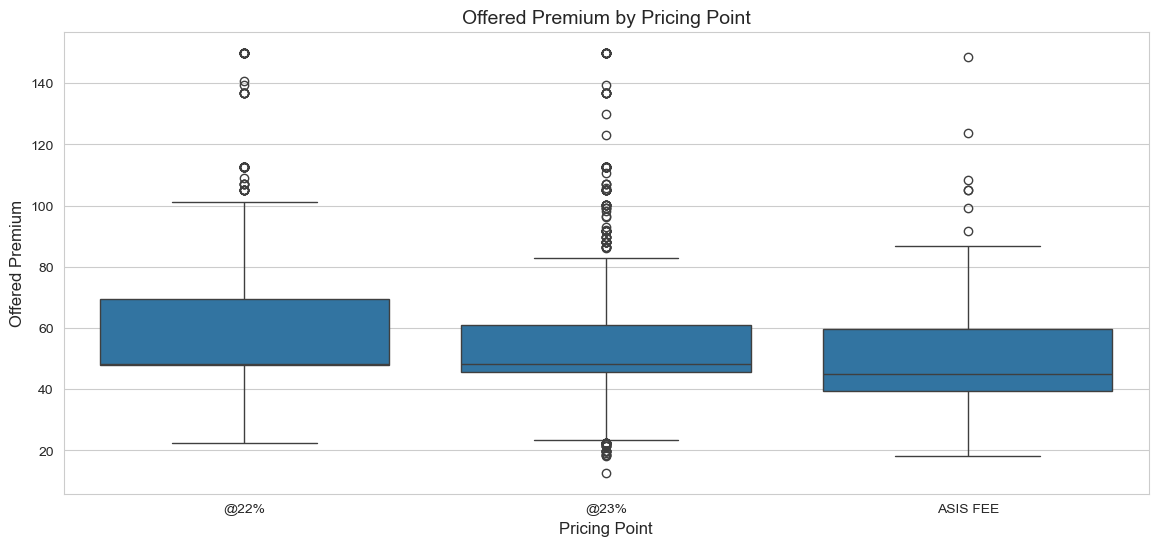

In [61]:
# =========================
# Boxplot: Offered Premium by Pricing Point
# =========================

# Create a figure with specified size
# We set figsize=(14,6) to make the plot wider and easier to read, especially when we have many pricing points
plt.figure(figsize=(14,6))

# Plot a boxplot using Seaborn
# x = "pricing_point" → categorical variable on the x-axis
# y = "offered_premium" → continuous variable on the y-axis to show distribution
# data = pricing_data → dataset containing the variables
sns.boxplot(x="pricing_point", y="offered_premium", data=pricing_data)

# Add a title and axis labels with larger fonts for readability
plt.title("Offered Premium by Pricing Point", fontsize=14)
plt.xlabel("Pricing Point", fontsize=12)
plt.ylabel("Offered Premium", fontsize=12)

# Save the plot as a PNG file for reporting or presentations
# dpi=300 ensures high resolution
# bbox_inches='tight' trims extra white space around the figure
plt.savefig("Charts/Offered Premium by Pricing Point_Boxplot_chart.png", dpi=300, bbox_inches='tight')  

# Display the plot
plt.show()


### How would you test (statistically) if they are different?  

#### 1. Do strategies differ in conversion?  
- Use **`sale_flag`** to test differences across pricing strategies.  
- Since `sale_flag` is categorical, apply a **Chi-Square Test of Independence**.  

**Hypotheses:**  
- **Null Hypothesis (H₀):** Conversion rates are the same across all pricing points.  
- **Alternative Hypothesis (H₁):** At least one pricing point has a significantly different conversion rate.  


In [62]:
#  Build a contingency table for statistical testing
import pandas as pd

# Create a cross-tabulation of pricing_point (rows) vs sale_flag (columns)
# This shows how many sales (1) and non-sales (0) occurred at each pricing point
contingency_table = pd.crosstab(pricing_data["pricing_point"], pricing_data["sale_flag"])
print(contingency_table)


sale_flag         0    1
pricing_point           
@22%           3059  863
@23%           2960  867
ASIS FEE        855  260


In [63]:
# Perform Chi-Square Test of Independence
# This test checks whether there is a significant relationship between pricing points and conversion outcome (sale_flag).
# Run the Chi-Square test on the contingency table
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display results
print("Chi-square Statistic:", chi2)                    # Test statistic value
print("Degrees of Freedom:", dof)                       # Number of independent comparisons
print("P-value:", p)                                    # Probability of observing results if H0 is true


Chi-square Statistic: 1.0230986086942098
Degrees of Freedom: 2
P-value: 0.5995659487275131


**Hypothesis Test Result**

- p-value = **0.599** (≫ 0.05)  
- Decision: **Fail to reject H₀**  
- Conclusion: There is **no statistical evidence** that conversion rates differ across pricing points.


#### 2. Average Price Levels Differ by Strategy?

- **Variable of interest**: `offered_premium`  
- Since `offered_premium` is continuous, first test for **normality** of distribution.  

**Steps**:
1. Check normality of `offered_premium`.  
   - If **p ≤ 0.05** → distribution is **not normal** → use **non-parametric tests**  
   - If **p > 0.05** → distribution is **normal** → use **parametric tests**  

**Hypotheses**:
- **Null (H₀):** The distribution of `offered_premium` is the same across strategies.  
- **Alternative (H₁):** At least one strategy has a different distribution.  


In [64]:
# Normality check for each pricing_point group using Kolmogorov-Smirnov (KS) test
normality_results = {}
for point in pricing_data["pricing_point"].unique():
    # Extract "offered_premium" values for the current pricing_point
    group = pricing_data.loc[pricing_data["pricing_point"] == point, "offered_premium"]
    
    # Standardize the group (mean=0, std=1) so it can be compared to a standard normal distribution
    group_std = (group - group.mean()) / group.std(ddof=0)

    # Perform KS test against the Normal(0,1) distribution
    stat, p = stats.kstest(group_std, 'norm')

    # Store p-values in dictionary for later reference
    normality_results[point] = p
    print(f"{point}: Kolmogorov-Smirnov test p-value = {p:.4f}")
    

# Variance homogeneity check using Levene’s test

# Collect offered_premium values grouped by pricing_point
groups = [pricing_data.loc[pricing_data["pricing_point"] == point, "offered_premium"]
          for point in pricing_data["pricing_point"].unique()]

# Test if variances are equal across groups
stat, p_var = stats.levene(*groups)
print(f"Levene’s test p-value = {p_var:.4f}")

# Statistical test selection based on assumptions

# If all groups are normally distributed AND have equal variance → ANOVA
if all(p > 0.05 for p in normality_results.values()) and p_var > 0.05:
    # ANOVA
    f_stat, p_val = stats.f_oneway(*groups)
    print(f"ANOVA result: F={f_stat:.4f}, p={p_val:.4f}")
else:
    # Otherwise, use the non-parametric Kruskal-Wallis test
    h_stat, p_val = stats.kruskal(*groups)
    print(f"Kruskal-Wallis result: H={h_stat:.4f}, p={p_val:.4f}")


@22%: Kolmogorov-Smirnov test p-value = 0.0000
@23%: Kolmogorov-Smirnov test p-value = 0.0000
ASIS FEE: Kolmogorov-Smirnov test p-value = 0.0000
Levene’s test p-value = 0.0005
Kruskal-Wallis result: H=188.3626, p=0.0000


**Normality (Kolmogorov-Smirnov Test)**

- Since all p-values are < 0.05, we reject the null hypothesis of normality. The data for all groups is not normally distributed.

**Non-Parametric (Kruskal-Wallis Test)**

- H = 188.3626, p = 0.0000

- Since p < 0.05, we reject null hypthesis and conclude there are statistically significant differences in the distributions of the groups.

**Homogeneity of Variance (Levene’s Test)**

p = 0.0005

Since p < 0.05, we reject the null hypothesis of equal variances. The groups do not have equal variance.

### 3. Do revenues differ by strategy?

- We use **sold_premium** to test revenue differences across pricing strategies.
- Since `sold_premium` is continuous, we first assess the normality of its distribution.

**Steps:**
1. Check normality of `sold_premium`.  
   - If **p ≤ 0.05** → distribution is **not normal** → use **non-parametric tests**.  
   - If **p > 0.05** → distribution is **normal** → use **parametric tests**.  

**Hypotheses:**
- **Null (H₀):** The distributions of revenue (`sold_premium`) are the same across all pricing strategies (`pricing_point`).  
- **Alternative (H₁):** At least one pricing strategy has a significantly different revenue distribution compared to the others.  


In [65]:
# Filter data to include only sold policies (sale_flag = 1), 
# since we're only interested in actual revenue
sold_data = pricing_data[pricing_data["sale_flag"] == 1]

# Create a list of arrays, each containing sold_premium values for a given pricing_point
groups = [group["sold_premium"].dropna().values 
          for name, group in sold_data.groupby("pricing_point")]

# Check normality of sold_premium distribution for each pricing_point using the Shapiro-Wilk test.
for name, group in sold_data.groupby("pricing_point"):
    stat, p = stats.shapiro(group["sold_premium"])
    print(f"{name}: Shapiro-Wilk p-value = {p:.4f}")

# Since data is likely non-normal, use the Kruskal-Wallis H-test  to test whether the sold_premium differs across pricing_point groups
stat, p = stats.kruskal(*groups)
print(f"Kruskal-Wallis result: H={stat:.4f}, p={p:.4f}")


@22%: Shapiro-Wilk p-value = 0.0000
@23%: Shapiro-Wilk p-value = 0.0000
ASIS FEE: Shapiro-Wilk p-value = 0.0000
Kruskal-Wallis result: H=62.1275, p=0.0000


**Normality Test (Shapiro–Wilk)**

- Since all p-values < 0.05, we reject the null hypothesis of normality. This means the data for all three groups is not normally distributed.

**Non-Parametric (Kruskal–Wallis Test)**

- H statistic = 62.1275, p-value = 0.0000
- Because p-value < 0.05, we reject the null hypothesis that the distributions of the groups are the same.
- This indicates there are statistically significant differences between the groups.

# 3. Compare the price elasticity of the strategies in the dataset: 

**Objective**
- To understand how sensitive customers are to changes in price for each pricing strategy.
- Specifically, we want to see how a change in average premium affects conversion rate.

**Elasticity Formula** = % change in conversion rate relative to the ASIS FEE group / % change in average premium relative to the ASIS FEE group.
- This gives a relative measure of sensitivity: how much conversion changes per 1% change in price.

**Why we compare against ASIS FEE:**
- ASIS FEE is treated as a baseline or reference group.
- Comparing other strategies to this baseline helps identify which strategies are more or less price-sensitive.

**Insights**
- Elastic (>1): Conversion changes a lot when price changes → customers are price-sensitive.

- Inelastic (<1): Conversion changes little when price changes → customers are less sensitive to price.

- Helps inform pricing decisions, e.g., whether a strategy can sustain higher premiums without losing sales.


In [66]:
# Extract the summary row where pricing_point is 'ASIS FEE' (baseline strategy)
asis = summary[summary['pricing_point'] == 'ASIS FEE']
print(asis)

# Get the conversion rate for ASIS baseline
asis_conversion = asis['conversion'].values[0]

# Get the average offered premium for ASIS baseline
asis_avg_price = asis['avg_offered_premium'].values[0]



  pricing_point  offers   avg_base  avg_offered_premium  avg_sold_premium  \
2      ASIS FEE    1115  48.973668            48.973668         49.572923   

   avg_price_increase  conversion  
2                 0.0    0.233184  


In [67]:
# Compute elasticity of demand for each pricing strategy compared to the baseline "ASIS FEE"

summary['elasticity_vs_ASIS'] = np.where(
    summary['pricing_point'] != 'ASIS FEE',
    # % change in conversion / % change in price
    ((summary['conversion'] - asis_conversion) / asis_conversion) /
    ((summary['avg_offered_premium'] - asis_avg_price) / asis_avg_price),
    None 
)

# Display results for all pricing points except ASIS
print(summary[summary['pricing_point'] != 'ASIS FEE'][[
    'pricing_point', 'conversion', 'avg_offered_premium', 'elasticity_vs_ASIS'
]])


  pricing_point  conversion  avg_offered_premium elasticity_vs_ASIS
0          @22%    0.220041             55.21643          -0.442165
1          @23%    0.226548             51.97665          -0.464082


- Negative values for both @22% (-0.442165) and @23% (-0.464082) relative to ASIS FEE indicate an inverse relationship between price and conversion:

    - If the price goes up, fewer customers buy (conversion goes down).

    - If the price goes down, more customers buy (conversion goes up).

- The magnitude of elasticity suggests that demand is inelastic, meaning customers are not highly sensitive to price changes.

- Practical interpretation:

    - A 1% increase in price leads to roughly a 0.45% decrease in conversion.

    - The effect is slightly stronger at @23% than @22%, but the difference is minor.

    - Since elasticity is between 0 and –1, moderate price increases are unlikely to drastically reduce conversions, and revenue could potentially increase with a slightly higher price.

### Withing Group Exploration

**About elasticity within a group:**
- Calculating within a group is possible by comparing conversion changes across different price points inside the same strategy.

- This shows how sensitive customers are within a single strategy, rather than relative to another strategy.

**Customer-related exploration based on plan_flag**

In [68]:
# Group the data by plan_flag and pricing_point
# Calculate the average offered premium for each group and conversion rate (mean of sale_flag) for each group
summary_plan = pricing_data.groupby(['plan_flag', 'pricing_point']).agg(
    avg_offered_premium=('offered_premium', 'mean'),
    conversion=('sale_flag', 'mean')
).reset_index()


# Display the summarized results
print(summary_plan)

   plan_flag pricing_point  avg_offered_premium  conversion
0          0          @22%            54.506320    0.160063
1          0          @23%            51.804485    0.169817
2          0      ASIS FEE            48.704564    0.170022
3          1          @22%            58.137419    0.466754
4          1          @23%            52.672569    0.455863
5          1      ASIS FEE            50.062262    0.488688


In [69]:
# Extract baseline values for ASIS pricing (per plan_flag)  
# These will be used as reference points for calculating elasticity
asis_baseline = summary_plan[summary_plan['pricing_point'] == 'ASIS FEE']
print(asis_baseline)

   plan_flag pricing_point  avg_offered_premium  conversion
2          0      ASIS FEE            48.704564    0.170022
5          1      ASIS FEE            50.062262    0.488688


In [70]:
# Define function to calculate price elasticity vs. ASIS baseline
# Formula: %ΔConversion / %ΔPrice relative to ASIS
def elasticity(row):
    # Get the ASIS values corresponding to the same plan_flag
    asis = asis_baseline[asis_baseline['plan_flag'] == row['plan_flag']]
    conv_asis = asis['conversion'].values[0]
    price_asis = asis['avg_offered_premium'].values[0]

    # Skip elasticity calculation for the ASIS row itself
    if row['pricing_point'] != 'ASIS FEE':
        return ((row['conversion'] - conv_asis)/conv_asis) / ((row['avg_offered_premium'] - price_asis)/price_asis)
    else:
        return None

In [71]:
# Apply elasticity calculation for each row of summary_plan
summary_plan['elasticity_vs_ASIS'] = summary_plan.apply(elasticity, axis=1)

In [72]:
# Remove ASIS rows from the output since their elasticity is undefined
summary_plan = summary_plan[summary_plan['pricing_point'] != 'ASIS FEE']

In [73]:
# Display key results for review
print(summary_plan[['plan_flag', 'pricing_point', 'conversion', 'avg_offered_premium', 'elasticity_vs_ASIS']])

   plan_flag pricing_point  conversion  avg_offered_premium  \
0          0          @22%    0.160063            54.506320   
1          0          @23%    0.169817            51.804485   
3          1          @22%    0.466754            58.137419   
4          1          @23%    0.455863            52.672569   

   elasticity_vs_ASIS  
0           -0.491721  
1           -0.018935  
3           -0.278259  
4           -1.288219  


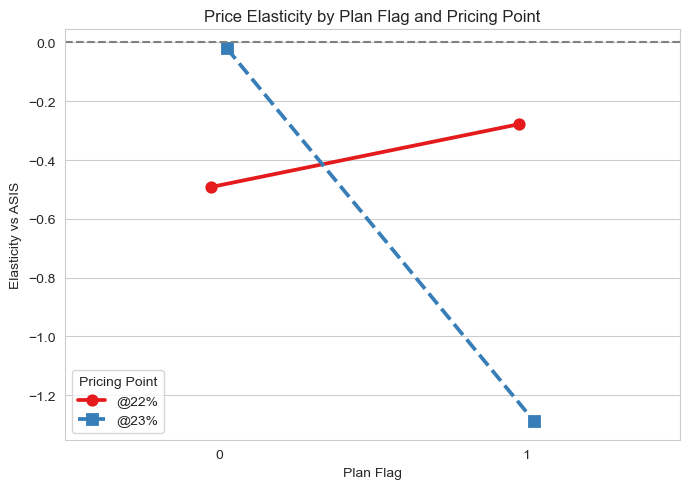

In [74]:
# Create a figure with specified size
plt.figure(figsize=(7,5))

# Draw a point plot to show price elasticity for each plan_flag
# - X-axis: plan_flag
# - Y-axis: elasticity_vs_ASIS
# - Hue: pricing_point (different colors for each pricing strategy)
# - dodge=True separates points for clarity
# - markers and linestyles differentiate pricing points visually
sns.pointplot(
    data=summary_plan,
    x='plan_flag',
    y='elasticity_vs_ASIS',
    hue='pricing_point',
    dodge=True,
    markers=['o', 's'],
    linestyles=['-', '--'],
    palette='Set1'
)

# Add a title and axis labels for clarity
plt.title("Price Elasticity by Plan Flag and Pricing Point")
plt.xlabel("Plan Flag")
plt.ylabel("Elasticity vs ASIS")

# Add a horizontal reference line at 0 to show positive vs negative elasticity
plt.axhline(0, color='gray', linestyle='--')

# Add legend with a descriptive title
plt.legend(title='Pricing Point')

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Save the plot as a high-resolution PNG for reports or presentations
plt.savefig("Charts/Price Elasticity by Plan Flag and Pricing Point_pointplot_chart.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


**Plan Flag 0 (no plan):**

- Conversion rates are low (0.16–0.17).

- Elasticity:

    - @22%: -0.491721 → moderately elastic (1% increase in price leads to about 0.49% decrease in conversion).

    - @23%: -0.018935 → Almost zero elasticity, meaning conversion hardly changes with price change at this level.Customers at this pricing point are essentially price-insensitive, even when the premium changes, conversion stays stable.

**Plan Flag 1 (with plan):**

- Conversion rates are higher (0.456–0.467), indicating that having a plan boosts likelihood of purchase.

- Elasticity:

    - @22%: -0.278 → fairly inelastic; small effect of price on conversion.

    - @23%: -1.288 → highly elastic; customers are very sensitive to price changes at this pricing point.

**Key Insights:**

- Customers with plans are generally less price-sensitive at @22%, but much more sensitive at @23%.

- Customers without plans are mostly inelastic, except for @23% where conversion is almost unaffected by price.

- Pricing strategy impacts price sensitivity differently for plan vs no-plan customers, which is important for revenue optimization.

**Appliance related exploration based on item_age**

In [75]:
# Convert 'item age' column to numeric values, replacing invalid entries with NaN
pricing_data['item age'] = pd.to_numeric(pricing_data['item age'], errors='coerce')

# Define bins (ranges of item age in days) and corresponding labels
bins = [-100, 0, 30, 180, 365, 730, 1100]  
labels = ['Pre-purchase', 'New', 'Young', 'Mid-age', 'Old', 'Very Old']

# Categorize each item into an age group based on the defined bins
pricing_data['item_age_group'] = pd.cut(pricing_data['item age'], bins=bins, labels=labels)


In [76]:
# Group by item age group and pricing point:
#   - Calculate average offered premium
#   - Calculate average conversion rate (mean of sale_flag)
summary_age = pricing_data.groupby(['item_age_group', 'pricing_point'],observed=True).agg(
    avg_offered_premium=('offered_premium', 'mean'),
    conversion=('sale_flag', 'mean')
).reset_index()

print(summary_age)

   item_age_group pricing_point  avg_offered_premium  conversion
0    Pre-purchase          @22%            57.484615    0.222851
1    Pre-purchase          @23%            53.953037    0.199492
2    Pre-purchase      ASIS FEE            52.447773    0.234818
3             New          @22%            53.952454    0.178696
4             New          @23%            51.397560    0.179563
5             New      ASIS FEE            48.217938    0.194158
6           Young          @22%            54.739535    0.213953
7           Young          @23%            51.868323    0.248447
8           Young      ASIS FEE            46.957542    0.245810
9         Mid-age          @22%            58.293632    0.363229
10        Mid-age          @23%            51.658286    0.419048
11        Mid-age      ASIS FEE            47.596875    0.390625
12            Old          @22%            55.756835    0.532374
13            Old          @23%            50.115497    0.596026
14            Old      AS

In [77]:
# Extract ASIS FEE pricing point for elasticity comparison
asis_age = summary_age[summary_age['pricing_point'] == 'ASIS FEE']


In [78]:
# Function to calculate price elasticity vs ASIS FEE for each age group
def elasticity_age(row):
# Get ASIS FEE values for the same item age group
    asis = asis_age[asis_age['item_age_group'] == row['item_age_group']]
    conv_asis = asis['conversion'].values[0]
    price_asis = asis['avg_offered_premium'].values[0]

     # Compute elasticity if not ASIS FEE
    if row['pricing_point'] != 'ASIS':
        return ((row['conversion'] - conv_asis)/conv_asis) / ((row['avg_offered_premium'] - price_asis)/price_asis)
    else:
        return None

# Apply elasticity calculation to each row
summary_age['elasticity_vs_ASIS'] = summary_age.apply(elasticity_age, axis=1)


C:\Users\pooja\AppData\Local\Temp\ipykernel_2688\4024704188.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return ((row['conversion'] - conv_asis)/conv_asis) / ((row['avg_offered_premium'] - price_asis)/price_asis)


In [79]:
# Remove ASIS FEE rows from final output (keep only comparisons)
summary_age = summary_age[summary_age['pricing_point'] != 'ASIS FEE']


In [80]:
# Display key metrics for each item age group and pricing point
print(summary_age[['item_age_group', 'pricing_point', 'conversion', 'avg_offered_premium', 'elasticity_vs_ASIS']])


   item_age_group pricing_point  conversion  avg_offered_premium  \
0    Pre-purchase          @22%    0.222851            57.484615   
1    Pre-purchase          @23%    0.199492            53.953037   
3             New          @22%    0.178696            53.952454   
4             New          @23%    0.179563            51.397560   
6           Young          @22%    0.213953            54.739535   
7           Young          @23%    0.248447            51.868323   
9         Mid-age          @22%    0.363229            58.293632   
10        Mid-age          @23%    0.419048            51.658286   
12            Old          @22%    0.532374            55.756835   
13            Old          @23%    0.596026            50.115497   
15       Very Old          @22%    0.600000            57.000000   
16       Very Old          @23%    0.500000            54.013333   

    elasticity_vs_ASIS  
0            -0.530674  
1            -5.241780  
3            -0.669619  
4            -1

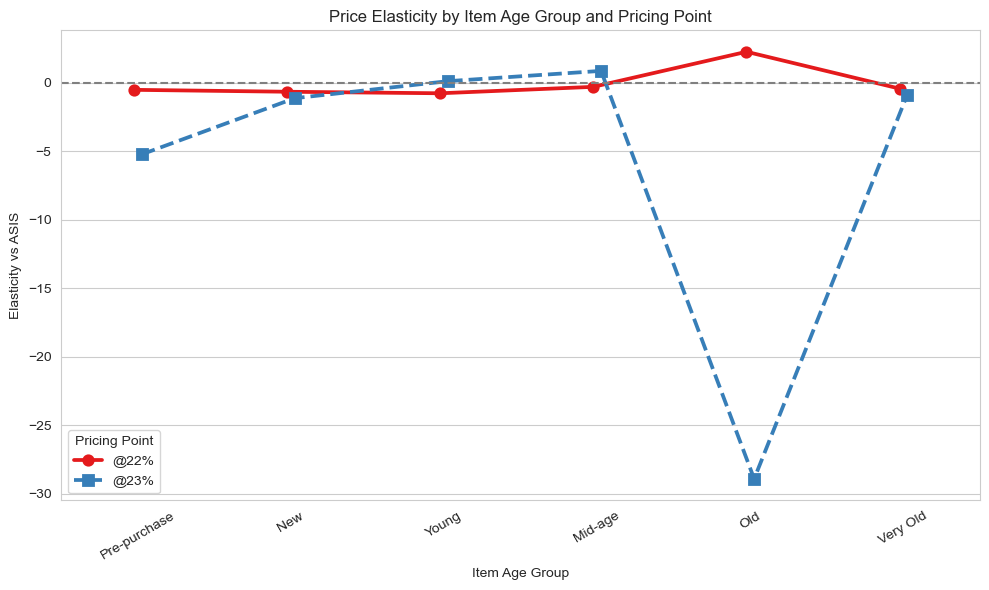

In [81]:
# Set the figure size for better readability
plt.figure(figsize=(10,6))

# Create a point plot to visualize price elasticity by item age group and pricing point
sns.pointplot(
    data=summary_age,                # Source DataFrame
    x='item_age_group',              # X-axis: item age categories
    y='elasticity_vs_ASIS',          # Y-axis: calculated price elasticity relative to ASIS
    hue='pricing_point',             # Differentiate lines/markers by pricing strategy
    dodge=True,                      # Separate points for each hue to avoid overlap
    markers=['o', 's'],              # Define marker shapes for each pricing point
    linestyles=['-', '--'],          # Define line styles for each pricing point
    palette='Set1'                   # Color palette for clear visual distinction
)

# Set plot title and axis labels
plt.title("Price Elasticity by Item Age Group and Pricing Point")
plt.xlabel("Item Age Group")
plt.ylabel("Elasticity vs ASIS")

# Add a horizontal reference line at 0 to easily distinguish positive vs negative elasticity
plt.axhline(0, color='gray', linestyle='--')  

# Add legend for pricing points
plt.legend(title='Pricing Point')

# Rotate x-axis labels for better readability
plt.xticks(rotation=30)

# Adjust layout to prevent clipping of labels and title
plt.tight_layout()

# Save the plot as a high-resolution PNG for reports or presentations
plt.savefig("Charts/Price Elasticity by Item Age Group and Pricing Point_pointplot_chart.png", 
            dpi=300, bbox_inches='tight')  

# Display the plot
plt.show()



- Older items (Mid-age, Old, Very Old) generally show higher conversion rates, especially at the @23% pricing point.  
- Younger or pre-purchase items tend to have lower conversions, suggesting price sensitivity or lower purchase intent.

**Magnitude of elasticity varies widely:**
  
- Some groups (e.g., Old @23%, Pre-purchase @23%) are very price-sensitive, small price changes cause large conversion shifts.
- Some groups (e.g., Young @23%, Mid-age @23%, Old @22%) show unusual or positive elasticity, suggesting other factors may influence conversion or pricing is out of normal range.

# 4. Assuming each pricing point is generated by a model at a different global constraint, would you be able to indicate: 
#### a.	Best model from the statistical point of view.


In [82]:
# Overall performance
# Calculate overall AUC (discrimination ability of model)
roc_auc = roc_auc_score(pricing_data['sale_flag'], pricing_data['predictedconversionrate'])

# Calculate overall Brier Score (calibration quality of model; lower is better)
brier = brier_score_loss(pricing_data['sale_flag'], pricing_data['predictedconversionrate'])

# Print overall performance metrics
print("Overall Model Performance")
print("AUC:", roc_auc, "Brier:", brier)

# For each pricing point, calculate AUC and Brier score
# This shows how well the model performs across different pricing levels
model_perf = pricing_data.groupby("pricing_point", group_keys=False).apply(
    lambda g: pd.Series({
        "AUC": roc_auc_score(g['sale_flag'], g['predictedconversionrate']),
        "Brier": brier_score_loss(g['sale_flag'], g['predictedconversionrate'])
    }),
     include_groups=False
).reset_index()

# Print model performance broken down by pricing point
print("\nModel Performance by Pricing Point")
print(model_perf)


Overall Model Performance
AUC: 0.6664334912853475 Brier: 0.22834448330324908

Model Performance by Pricing Point
  pricing_point       AUC     Brier
0          @22%  0.714835  0.148685
1          @23%  0.713921  0.153097
2      ASIS FEE  0.500000  0.766816


**Overall Model Performance**
- AUC (0.6663): Here, 0.666 suggests the model can distinguish between buyers and non-buyers somewhat effectively, but there’s room for improvement.
- Brier Score (0.2285): At 0.228, the model predictions are reasonably well-calibrated but still have noticeable error.

**Model Performance by Pricing Point**
- The model performs best at 22% and 23% pricing points, where both AUC and Brier scores are strong.
- At the ASIS FEE level, the model fails to distinguish between buyers and non-buyers, suggesting that this pricing strategy is ineffective and possibly misleading the model.


#### b. Pricing point of view (revenue)

In [91]:
# Revenue & Profit EV by pricing_point
summary = pricing_data.groupby("pricing_point").apply(lambda g: pd.Series({
    # Conversion rate = % of sold offers
    "conversion": g["sale_flag"].mean(),

    # Average sold premium (only where sale_flag=1)
    "avg_sold_premium": g.loc[g["sale_flag"] == 1, "sold_premium"].mean(),

    # Expected claim cost per sold policy
    "expected_claim_cost": g.loc[g["sale_flag"] == 1, "claim_amount"].mean(),
}),include_groups=False).reset_index()

# Compute Expected Value (per offer)
summary["EV_revenue"] = summary["conversion"] * summary["avg_sold_premium"]

print(summary)


  pricing_point  conversion  avg_sold_premium  expected_claim_cost  EV_revenue
0          @22%    0.220041         55.768714            58.458030   12.271392
1          @23%    0.226548         51.482768            49.169227   11.663329
2      ASIS FEE    0.233184         49.572923            46.395692   11.559605


We compared three pricing strategies based on their conversion rates, average sold premiums, expected claim costs, and expected revenue (EV).  

- **@22%**: Highest EV revenue (**12.27**), driven by a higher premium despite lower conversion.  
- **@23%**: Moderate EV revenue (**11.66**) with a balance between premium and conversion.  
- **ASIS FEE**: Lowest EV revenue (**11.54**) despite slightly higher conversion, due to lower premium and higher claim cost impact.  

From a revenue perspective, the **@22% pricing point** is the best-performing model.  


#### c. Would you say these models are biased?

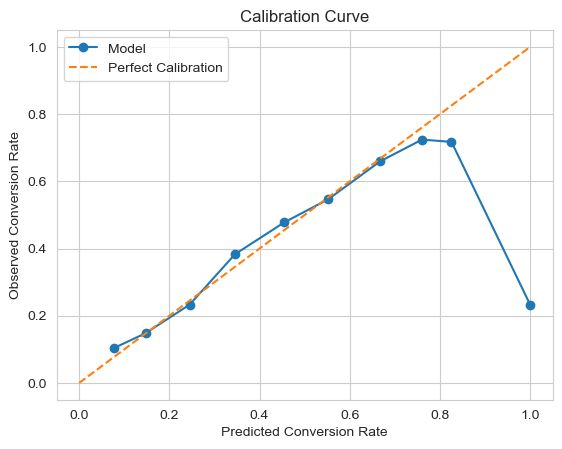

Calibration Intercept (ideal ~0): -1.6665277896694655
Calibration Slope (ideal ~1): 1.2382014053512382

Bias by Pricing Point
  pricing_point  avg_predicted_conversion  actual_conversion      bias
0          @22%                  0.212279           0.220041 -0.007761
1          @23%                  0.222569           0.226548 -0.003980
2      ASIS FEE                  1.000000           0.233184  0.766816


In [84]:

# Overall Calibration Check
prob_true, prob_pred = calibration_curve(pricing_data['sale_flag'], 
                                         pricing_data['predictedconversionrate'], 
                                         n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0, 1], [0, 1], linestyle='--', label="Perfect Calibration")
plt.xlabel("Predicted Conversion Rate")
plt.ylabel("Observed Conversion Rate")
plt.title("Calibration Curve")
plt.legend()

plt.savefig("Charts/Calibration Curve_lineplot_chart.png", dpi=300, bbox_inches='tight')
plt.show()

# Calibration Slope & Intercept (statistical bias test)
lr = LogisticRegression(solver="lbfgs")
lr.fit(pricing_data['predictedconversionrate'].values.reshape(-1, 1), 
       pricing_data['sale_flag'])
slope = lr.coef_[0][0]
intercept = lr.intercept_[0]

print("Calibration Intercept (ideal ~0):", intercept)
print("Calibration Slope (ideal ~1):", slope)

# Group-level bias check by pricing point
bias_by_price = pricing_data.groupby("pricing_point").apply(
    lambda g: pd.Series({
        "avg_predicted_conversion": g["predictedconversionrate"].mean(),
        "actual_conversion": g["sale_flag"].mean(),
        "bias": g["predictedconversionrate"].mean() - g["sale_flag"].mean()
    }),include_groups=False
).reset_index()

print("\nBias by Pricing Point")
print(bias_by_price)


**Calibration Findings**

**Calibration Intercept:** -1.67 (ideal ≈ 0) → The model systematically underestimates conversion probabilities.

**Calibration Slope:** 1.24 (ideal ≈ 1) → Predictions are slightly over-dispersed, meaning low probabilities are underestimated and high probabilities are overestimated.

**Bias by Pricing Point**

- @22%: Predicted conversion (0.212) is slightly lower than actual (0.220) → small underprediction.

- @23%: Predicted conversion (0.223) is close to actual (0.227) → well-calibrated.

- ASIS FEE: Predicted conversion (1.0) is much higher than actual (0.233) → severe overprediction bias.

## 5. Claims information are also provided, is there any direct relationship between conversion and claims?

**Calculate Loss Ratio on the Sold Cohort**

Now we focus only on customers who actually purchased the policy (sale_flag = 1).
We calculate Loss Ratio = Total Claims ÷ Total Premium, per pricing strategy.

If Loss Ratio > 1  → unprofitable (claims cost more than premium).

If Loss Ratio < 1  → profitable (premiums cover claims).

In [85]:
# # Keep only sold policies
sold_data = pricing_data[pricing_data["sale_flag"] == 1]

# Aggregate total claims and premiums by pricing_point
loss_ratio = (
    sold_data.groupby("pricing_point")
    .agg({"claim_amount": "sum", "offered_premium": "sum"})
    .assign(loss_ratio=lambda x: x["claim_amount"] / x["offered_premium"])
    .reset_index()
)

# Display results
print(loss_ratio)


  pricing_point  claim_amount  offered_premium  loss_ratio
0          @22%      50449.28         48128.40    1.048223
1          @23%      42629.72         44635.56    0.955062
2      ASIS FEE      12062.88         12888.96    0.935908


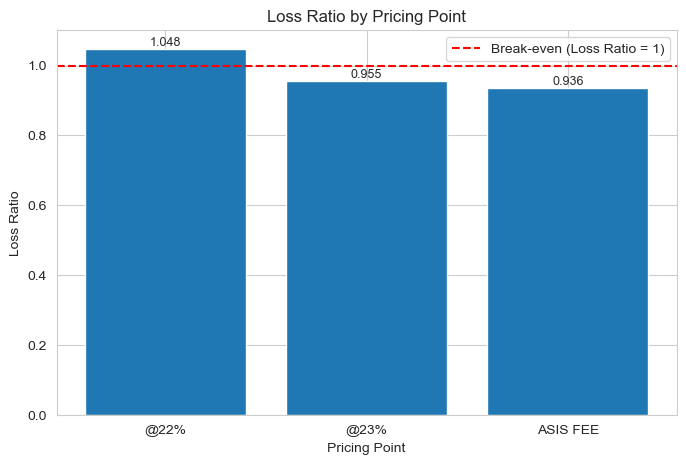

In [86]:
import matplotlib.pyplot as plt

# ===============================
# Loss Ratio Bar Chart by Pricing Point
# ===============================

# Set figure size for readability
plt.figure(figsize=(8,5))

# Create a bar chart:
# X-axis: pricing points
# Y-axis: corresponding loss ratio values
bars = plt.bar(loss_ratio["pricing_point"], loss_ratio["loss_ratio"])

# Add a horizontal reference line at 1 (break-even point)
plt.axhline(1, color="red", linestyle="--", label="Break-even (Loss Ratio = 1)")

# Add value labels on top of each bar for clarity
for bar in bars:
    height = bar.get_height()  # Get bar height
    plt.text(
        bar.get_x() + bar.get_width()/2,  # X position = center of bar
        height,                            # Y position = top of bar
        f"{height:.3f}",                   # Format value to 3 decimals
        ha="center", va="bottom", fontsize=9
    )

# Set axis labels and plot title
plt.xlabel("Pricing Point")
plt.ylabel("Loss Ratio")
plt.title("Loss Ratio by Pricing Point")

# Add legend for reference line
plt.legend()

# Optional: zoom in on Y-axis if needed
# plt.ylim(0.49, 0.56)  

# Save the chart as a high-resolution PNG for reports or presentations
plt.savefig("Charts/Loss Ratio by Pricing Point_barplot_chart.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

**Direct Correlation of Claims with Conversion**

- Correlation gives a measure of linear relationship between conversion and claims.
- Using Pearson Correlation
    - Measures the strength and direction of a linear relationship between two continuous variables.
    - Pearson correlation helps quantify whether higher conversions are associated with higher claims, and if the relationship is positive or negative.
 - Range: Values range from -1 to +1:
    - +1 → perfect positive linear relationship
    - 0 → no linear relationship
    - -1 → perfect negative linear relationship

In [87]:
# Using Pearson correlation
corr_count = pricing_data[['sale_flag', 'claims_count']].corr().loc['sale_flag','claims_count']
corr_amount = pricing_data[['sale_flag', 'claim_amount']].corr().loc['sale_flag','claim_amount']

print(f"Correlation between conversion and claim count: {corr_count:.3f}")
print(f"Correlation between conversion and claim amount: {corr_amount:.3f}")


Correlation between conversion and claim count: 0.148
Correlation between conversion and claim amount: 0.084


**Interpretation of Correlation Results**

Conversion vs Claim Count (0.148): There is a weak positive relationship, meaning policies that are sold tend to have slightly higher claim counts, but the effect is small.

Conversion vs Claim Amount (0.084): There is a very weak positive relationship, indicating sold policies have marginally higher claim amounts, but the association is almost negligible.

Overall: Conversion and claims are not strongly related in this dataset, suggesting that higher sales do not necessarily lead to substantially higher claims.

**Profit/Loss Value on Average per Offer**

Expected Value (EV) tells us how much profit or loss the company makes on average per offer, given both:

- Conversion rate (likelihood of sale).

- Profit margin (premium collected − claim cost).

Formula:
EV = Conversion Rate × ( Average Premium − Average Claim Cost)

This balances probability of sale with profitability of each sale.

In [89]:
# Conversion rate per pricing_point
conversion = pricing_data.groupby("pricing_point")["sale_flag"].mean().reset_index(name="conversion_rate")

# Average claim cost per policy offered
avg_claims = pricing_data.groupby("pricing_point")["claim_amount"].mean().reset_index(name="avg_claim_cost")


# Average premium offered per policy
avg_premium = pricing_data.groupby("pricing_point")["offered_premium"].mean().reset_index(name="avg_premium")

# Merge conversion, claims, and premium info
ev = conversion.merge(avg_claims, on="pricing_point").merge(avg_premium, on="pricing_point")

# Compute expected value per offer
ev["expected_value"] = ev["conversion_rate"] * (ev["avg_premium"] - ev["avg_claim_cost"])

# Display results
print(ev)


  pricing_point  conversion_rate  avg_claim_cost  avg_premium  expected_value
0          @22%         0.220041       24.487246    55.216430        6.761674
1          @23%         0.226548       27.333371    51.976650        5.582891
2      ASIS FEE         0.233184       21.692978    48.973668        6.361417


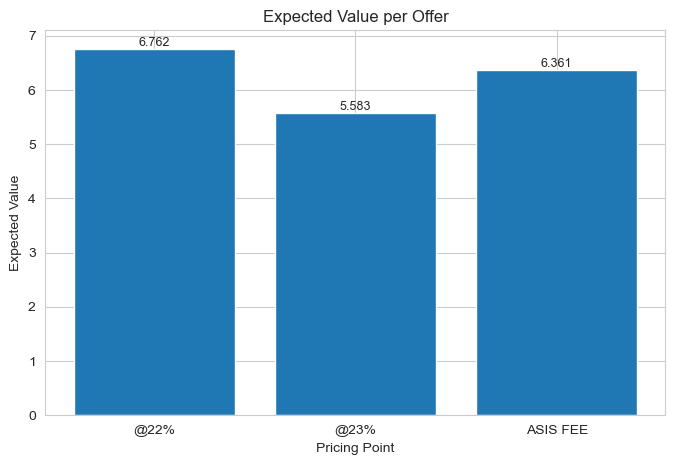

In [90]:
import matplotlib.pyplot as plt

# Expected Value bar chart with labels
plt.figure(figsize=(8,5))
bars = plt.bar(ev["pricing_point"], ev["expected_value"], label="Expected Value")


# Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   # X position (center of bar)
        height,                            # Y position (bar height)
        f"{height:.3f}",                   # Format value
        ha="center", va="bottom", fontsize=9
    )

# Titles and labels
plt.xlabel("Pricing Point")
plt.ylabel("Expected Value")
plt.title("Expected Value per Offer")

# Save the chart as a high-resolution PNG for reports or presentations
plt.savefig("Charts/Expected Value per Offer_barplot_chart.png", dpi=300, bbox_inches='tight')
plt.show()



**Conversion Rate vs. Claim Cost:**

As the conversion rate increases from 0.220 (@22%) to 0.233 (ASIS FEE), the average claim cost fluctuates. At @23%, although conversion rate improves slightly compared to @22%, the claim cost is highest (27.33), which reduces profitability. In contrast, ASIS FEE maintains the highest conversion rate while keeping claim cost relatively low (21.65).

**Impact on Expected Value (EV):**

- @22% produces the highest EV (6.76), driven by a good balance between premium and claim cost.

- @23% results in the lowest EV (5.58) because higher claims outweigh the benefit of improved conversions.

- ASIS FEE achieves a strong balance with EV (6.36), supported by both higher conversions and lower claim costs.